In [1]:
module("load", "cuda/10.2")
module("load","pytorch/gpu-cuda-10.2/1.8.0")
module("load", "tensorflow/gpu-cuda-10.2/2.3.0")

In [2]:
import tensorflow as tf

2021-11-26 10:22:38.745928: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2


In [3]:
tf.__version__

'2.3.0'

In [4]:
import numpy as np
import pandas as pd
import torch
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import sklearn as sk
from torch.optim import Optimizer
import wandb

In [5]:
import pickle

In [6]:
from transformers import TrainingArguments, Trainer
from transformers import AdamW, BertTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from sklearn.preprocessing import StandardScaler
import gc

In [7]:
from transformers import BertModel, BertTokenizer
import re

In [8]:
import torch.nn as nn
import time
from torch.autograd import Variable
import torch.nn.functional as F

In [9]:
import matplotlib.pyplot as plt

In [10]:
wandb.init(project="prot_bert_bfd_embeddings", entity="jlrestrepol")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jlrestrepol (use `wandb login --relogin` to force relogin)
2021-11-26 10:23:21.976834: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2


In [11]:
%env WANDB_LOG_MODEL=true

env: WANDB_LOG_MODEL=true


In [12]:
device_name = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if device_name.type != 'cuda':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: cuda


In [13]:
global path
path = {'data':"./", 'models':'./'}

In [14]:
def train_val_set(charge = np.nan):
    """Function that outputs train and validation set for a given charge state"""
    fig1 = pd.read_pickle(path['data']+'Fig1_powerlaw.pkl')#loads in raw training data
    fig1 = fig1[fig1['Modified sequence'].str.find('(')==-1]#Unmodified seqs
    fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].str.replace('_','')
    fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].str.replace('', ' ')
    fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].apply(lambda x : x[1:-1])
    label_complete = (fig1['CCS'] - fig1['predicted_ccs']).values#residual
    features = fig1[fig1['Charge'] == charge]['Modified sequence']#choose points with given charge, drop charge feature because of 2 heads
    label = label_complete[fig1['Charge'] == charge]#choose appropiate residuals
    x_train, x_val, y_train, y_val = model_selection.train_test_split(features, label, test_size = 0.1, random_state=42)#train/val set split
    global label_scaler
    label_scaler = StandardScaler()
    label_scaler.fit(y_train.reshape(-1, 1))
    y_train = label_scaler.transform(y_train.reshape(-1, 1))
    y_val = label_scaler.transform(y_val.reshape(-1, 1))
    print(f"The Initial Mean Squared Error is: {sk.metrics.mean_squared_error(fig1['CCS'], fig1['predicted_ccs'])}")#prints initial error
    return x_train, x_val, y_train, y_val

In [15]:
checkpoint = "Rostlab/prot_bert_bfd"
tokenizer = BertTokenizer.from_pretrained(checkpoint, do_lower_case=False )
model = BertModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
x_train, x_val, y_train, y_val = train_val_set(2)
train_tokenized = tokenizer(x_train.values.tolist(), padding='max_length', return_tensors='pt', max_length = 42)
val_tokenized = tokenizer(x_val.values.tolist(), padding='max_length', return_tensors='pt', max_length = 42)

The Initial Mean Squared Error is: 384.9004049893965


/u/jrlopez/conda-envs/ccs/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2229: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


In [21]:
def test_set(charge = np.nan):
    """Function that outputs train and validation set for a given charge state"""
    fig4 = pd.read_pickle(path['data']+'Fig4_powerlaw.pkl')#loads in raw training data
    fig4 = fig4[fig4['Modified_sequence'].str.find('(')==-1]#Unmodified seqs
    fig4.loc[:,'Modified_sequence'] = fig4['Modified_sequence'].str.replace('_','')
    fig4.loc[:,'Modified_sequence'] = fig4['Modified_sequence'].str.replace('', ' ')
    fig4.loc[:,'Modified_sequence'] = fig4['Modified_sequence'].apply(lambda x : x[1:-1])
    label_complete = (fig4['CCS'] - fig4['predicted_ccs']).values#residual
    x_test = fig4[fig4['Charge'] == charge]['Modified_sequence']#choose points with given charge, drop charge feature because of 2 heads
    y_test = label_complete[fig4['Charge'] == charge]#choose appropiate residuals
    print(f"The Initial Mean Squared Error is: {sk.metrics.mean_squared_error(fig4['CCS'], fig4['predicted_ccs'])}")#prints initial error
    return x_test, y_test

In [22]:
x_test, y_test = test_set(charge = 2)

The Initial Mean Squared Error is: 462.8173100703641


In [31]:
y_test = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

In [32]:
test_tokenized = tokenizer(x_test.values.tolist(), padding='max_length', return_tensors='pt', max_length = 42)

# Train/Val set 

## Train Set

In [17]:
if False:
    step = 100000
    with torch.no_grad():
        for n in range(1,2):
            print(n)
            model = BertModel.from_pretrained(checkpoint)
            dictionary = {'input_ids': train_tokenized['input_ids'][n*step:(n+1)*step],
                          'token_type_ids': train_tokenized['token_type_ids'][n*step:(n+1)*step],
                          'attention_mask': train_tokenized['attention_mask'][n*step:(n+1)*step]}
            train_embeddings = model(**dictionary)[0]
            with open(f'./embeddings/train_{n}.pickle', 'wb') as handle:
                pickle.dump(train_embeddings, handle, protocol = 4)
        
        
        print((n+1)*step)
        dictionary = {'input_ids': train_tokenized['input_ids'][(n+1)*step:],
                      'token_type_ids': train_tokenized['token_type_ids'][(n+1)*step:],
                      'attention_mask': train_tokenized['attention_mask'][(n+1)*step:]}
        train_embeddings = model(**dictionary)[0]
        with open(f'./embeddings/train_{n+1}.pickle', 'wb') as handle:
                pickle.dump(train_embeddings, handle, protocol = 4)

1


Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


200000


In [22]:
with open(f'./embeddings/train_0.pickle', 'rb') as pickle_file:
    part0 = pickle.load(pickle_file)

In [23]:
with open(f'./embeddings/train_1.pickle', 'rb') as pickle_file:
    part1 = pickle.load(pickle_file)

In [26]:
with open(f'./embeddings/train_2.pickle', 'rb') as pickle_file:
    part2 = pickle.load(pickle_file)

In [35]:
train_tensor = torch.cat((part0, part1, part2), 0)
train_tensor.shape

torch.Size([288585, 42, 1024])

In [36]:
with open(f'./embeddings/train_complete.pickle', 'wb') as handle:
        pickle.dump(train_tensor, handle, protocol = 4)

In [35]:
y_train = torch.tensor(y_train.flatten(), dtype=torch.float32)

In [38]:
with open(f'./embeddings/train_labels.pickle', 'wb') as handle:
        pickle.dump(y_train, handle, protocol = 4)

## Val Set

In [27]:
with torch.no_grad():
    model = BertModel.from_pretrained(checkpoint)
    val_embeddings = model(**val_tokenized)

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
with open(f'./embeddings/val_complete.pickle', 'wb') as handle:
        pickle.dump(val_embeddings, handle, protocol = 4)

In [33]:
y_val = torch.tensor(y_val.flatten(), dtype=torch.float32)

In [34]:
with open(f'./embeddings/val_labels.pickle', 'wb') as handle:
        pickle.dump(y_val, handle, protocol = 4)

# Test Set

In [33]:
with torch.no_grad():
    model = BertModel.from_pretrained(checkpoint)
    test_embeddings = model(**test_tokenized)

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
with open(f'./embeddings/test_complete.pickle', 'wb') as handle:
        pickle.dump(test_embeddings, handle, protocol = 4)

In [37]:
y_test = torch.reshape(y_test, (-1,))

In [38]:
with open(f'./embeddings/test_labels.pickle', 'wb') as handle:
        pickle.dump(y_test, handle, protocol = 4)

# Load-in train, val and test set

In [17]:
with open(f'../../embeddings/train_complete.pickle', 'rb') as pickle_file:
    x_train = pickle.load(pickle_file)
    #x_train = torch.mean(x_train, axis = 1)

In [18]:
with open(f'../../embeddings/val_complete.pickle', 'rb') as pickle_file:
    x_val = pickle.load(pickle_file)[0]
    #x_val = torch.mean(x_val, axis = 1)

In [19]:
with open(f'../../embeddings/test_complete.pickle', 'rb') as pickle_file:
    x_test = pickle.load(pickle_file)[0]
    #x_test = torch.mean(x_test, axis = 1)

In [21]:
with open(f'../../embeddings/train_labels.pickle', 'rb') as pickle_file:
    y_train = pickle.load(pickle_file)

In [23]:
with open(f'../../embeddings/val_labels.pickle', 'rb') as pickle_file:
    y_val = pickle.load(pickle_file)

In [24]:
with open(f'../../embeddings/test_labels.pickle', 'rb') as pickle_file:
    y_test = pickle.load(pickle_file)

In [25]:
y_train = y_train.view(len(y_train), 1)
y_val = y_val.view(len(y_val), 1)
y_test = y_test.view(len(y_test), 1)

# CNN

## Kim CNN

In [39]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        return logit

In [40]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = 1
kernel_num = 2
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [41]:
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

# Optimizer and Trainig

In [46]:
n_epochs = 30
batch_size = 64
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [43]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1


In [44]:
x_train.shape[0] / (10 *20)

1442.925

In [47]:
train_losses, val_losses, train_losses_scaled, val_losses_scaled = [], [], [], []

wandb.watch(model)

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0
    train_loss_scaled = 0
    val_loss_scaled = 0

    model.train(True)
    batch_idx = 0
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        preds_scaled = label_scaler.inverse_transform(y_pred.detach().numpy().reshape(-1, 1))
        labels_scaled = label_scaler.inverse_transform(y_batch.detach().numpy().reshape(-1, 1))
        mse_scaled = mean_squared_error(preds_scaled, labels_scaled)
        train_loss_scaled += mse_scaled.item()
        
    train_loss /= batch
    train_losses.append(train_loss)
    train_loss_scaled /= batch
    train_losses_scaled.append(train_loss_scaled)
    wandb.log({"loss_train": train_loss, "loss_train_scaled":train_loss_scaled})
    
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
            
            preds_scaled = label_scaler.inverse_transform(y_pred.detach().numpy().reshape(-1, 1))
            labels_scaled = label_scaler.inverse_transform(y_batch.detach().numpy().reshape(-1, 1))
            mse_scaled = mean_squared_error(preds_scaled, labels_scaled)
            val_loss_scaled += mse_scaled.item() 
        
        val_loss /= batch
        val_losses.append(val_loss)
        val_loss_scaled /= batch
        val_losses_scaled.append(val_loss_scaled)
        wandb.log({"loss_val": val_loss, "loss_val_scaled":val_loss_scaled})
        
    print(
        "Epoch %d Train loss: %.2f. Train Loss Scaled: %.2f Validation loss: %.2f. Validation loss scaled: %.2f, Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], train_losses_scaled[-1], val_losses[-1], val_losses_scaled[-1], elapsed)
    )

Epoch 1 Train loss: 0.63. Train Loss Scaled: 89.38 Validation loss: 0.52. Validation loss scaled: 73.36, Elapsed time: 46.47s.
Epoch 2 Train loss: 0.63. Train Loss Scaled: 89.06 Validation loss: 0.52. Validation loss scaled: 73.92, Elapsed time: 46.53s.
Epoch 3 Train loss: 0.62. Train Loss Scaled: 88.71 Validation loss: 0.52. Validation loss scaled: 73.63, Elapsed time: 46.59s.
Epoch 4 Train loss: 0.62. Train Loss Scaled: 88.73 Validation loss: 0.51. Validation loss scaled: 73.27, Elapsed time: 46.62s.
Epoch 5 Train loss: 0.62. Train Loss Scaled: 88.63 Validation loss: 0.52. Validation loss scaled: 73.90, Elapsed time: 46.57s.
Epoch 6 Train loss: 0.62. Train Loss Scaled: 88.91 Validation loss: 0.51. Validation loss scaled: 73.22, Elapsed time: 46.84s.
Epoch 7 Train loss: 0.62. Train Loss Scaled: 88.60 Validation loss: 0.52. Validation loss scaled: 74.48, Elapsed time: 46.59s.
Epoch 8 Train loss: 0.62. Train Loss Scaled: 88.62 Validation loss: 0.52. Validation loss scaled: 73.47, Elapse

In [83]:
charge = 2
fig1 = pd.read_pickle(path['data']+'Fig1_powerlaw.pkl')#loads in raw training data
fig1 = fig1[fig1['Modified sequence'].str.find('(')==-1]#Unmodified seqs
fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].str.replace('_','')
fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].str.replace('', ' ')
fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].apply(lambda x : x[1:-1])
label_complete = (fig1['CCS'] - fig1['predicted_ccs']).values#residual
features = fig1[fig1['Charge'] == charge]['Modified sequence']#choose points with given charge, drop charge feature because of 2 heads
label = label_complete[fig1['Charge'] == charge]#choose appropiate residuals
x_train_np, x_test_np, y_train_np, y_test_np = model_selection.train_test_split(features, label, test_size = 0.1, random_state=42)#train/val set split

In [97]:
pred_ccs = y_pred.detach().numpy().flatten() + fig1.loc[x_test_np.index]['predicted_ccs'].values

In [98]:
ccs = fig1.loc[x_test_np.index]['CCS'].values

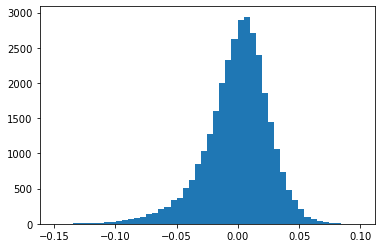

In [101]:
_ = plt.hist((pred_ccs-ccs)/pred_ccs, bins = 50)

# PyImageCNN

In [22]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [25]:
from wandb.keras import WandbCallback

In [23]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2021-11-19 17:48:46.718959: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-19 17:48:46.720806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:31:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.305GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-11-19 17:48:46.720833: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
2021-11-19 17:48:46.795919: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-19 17:48:46.816870: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-11-19 17:48:46.836012: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
20

In [24]:
def create_cnn(width, height, depth, filters=(2, 3, 4), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
        # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 1024), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

In [28]:
n_epochs = 30
model = create_cnn(x_train.shape[2], x_train.shape[1], 1, regress=True)
opt = Adam(lr=5e-3)
model.compile(loss="mean_squared_error", optimizer=opt)

In [ ]:
print("[INFO] training model...")
history = model.fit(x=x_train.detach().numpy(), y=y_train.detach().numpy(), 
    validation_data=(x_val.detach().numpy(), y_val.detach().numpy()),
    epochs=n_epochs, batch_size=64, verbose=1, callbacks=[WandbCallback()])

[INFO] training model...
Epoch 1/30
4510/4510 [==============================] - 1174s 260ms/step - loss: 0.6350 - val_loss: 0.5522
Epoch 2/30
4510/4510 [==============================] - 1157s 257ms/step - loss: 0.5519 - val_loss: 0.5080
Epoch 3/30
4510/4510 [==============================] - 1156s 256ms/step - loss: 0.5254 - val_loss: 0.5125
Epoch 4/30
4510/4510 [==============================] - 1157s 256ms/step - loss: 0.5030 - val_loss: 0.5456
Epoch 5/30
4510/4510 [==============================] - 1157s 257ms/step - loss: 0.4862 - val_loss: 0.5483
Epoch 6/30
4510/4510 [==============================] - 1156s 256ms/step - loss: 0.4721 - val_loss: 0.5497
Epoch 7/30
4510/4510 [==============================] - 1157s 256ms/step - loss: 0.4621 - val_loss: 0.5191
Epoch 8/30
4510/4510 [==============================] - 1159s 257ms/step - loss: 0.4510 - val_loss: 0.5562
Epoch 9/30
4510/4510 [==============================] - 1158s 257ms/step - loss: 0.4452 - val_loss: 0.5108
Epoch 10/30


In [ ]:
opt = Adam(lr=1e-3)
model.compile(loss="mean_squared_error", optimizer=opt)
history = model.fit(x=x_train.detach().numpy(), y=y_train.detach().numpy(), 
    validation_data=(x_val.detach().numpy(), y_val.detach().numpy()),
    epochs=n_epochs, batch_size=64, verbose=1, callbacks=[WandbCallback()])

# Transformer

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from wandb.keras import WandbCallback

In [52]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [53]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [54]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [55]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
    def get_config(self):
        config = {
        'd_model': self.d_model,
        'warmup_steps': self.warmup_steps,
         }
        return config

In [60]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2021-11-22 21:41:13.423001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:4b:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.305GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-11-22 21:41:13.423081: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
2021-11-22 21:41:13.423105: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-22 21:41:13.423120: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-11-22 21:41:13.423136: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2021-11-22 21:41:13.423150: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusolver.so.

In [56]:
embed_dim = 1024  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

#inputs = layers.Input(shape=(maxlen,))
#embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
#x = embedding_layer(inputs)

inputs = layers.Input(shape=(embed_dim,))
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(inputs)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="linear")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(CustomSchedule(embed_dim), beta_1=0.9, beta_2=0.98, 
                                 epsilon=1e-9)

2021-11-22 21:37:43.688042: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-22 21:37:43.745662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:4b:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.305GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-11-22 21:37:43.745712: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
2021-11-22 21:37:43.748146: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-22 21:37:43.750447: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-11-22 21:37:43.750928: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
20

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [13]:
x_train_numpy = x_train.detach().numpy()
x_val_numpy = x_val.detach().numpy()
x_test_numpy = x_test.detach().numpy()
y_train_numpy = y_train.detach().numpy()
y_test_numpy = y_test.detach().numpy()
y_val_numpy = y_val.detach().numpy()

In [62]:
print(len(x_train_numpy), "Training data")
print(len(x_val_numpy), "Test data")

model.compile(loss="mean_squared_error", optimizer=optimizer)
history = model.fit(
    x_train_numpy, y_train_numpy, batch_size=64, epochs=30, validation_data=(x_val_numpy, y_val_numpy), callbacks=[WandbCallback()]
)

288585 Training data
32066 Test data
Epoch 1/30
4510/4510 [==============================] - 22s 5ms/step - loss: 0.5943 - val_loss: 0.5348
Epoch 2/30
4510/4510 [==============================] - 21s 5ms/step - loss: 0.5920 - val_loss: 0.5326
Epoch 3/30
4506/4510 [============================>.] - ETA: 0s - loss: 0.5893

wandb: ERROR Can't save model, h5py returned error: Layer TransformerBlock has arguments in `__init__` and therefore must override `get_config`.


4510/4510 [==============================] - 21s 5ms/step - loss: 0.5893 - val_loss: 0.5230
Epoch 4/30
4510/4510 [==============================] - 21s 5ms/step - loss: 0.5904 - val_loss: 0.5283
Epoch 5/30
4510/4510 [==============================] - 21s 5ms/step - loss: 0.5847 - val_loss: 0.5412
Epoch 6/30
4510/4510 [==============================] - 22s 5ms/step - loss: 0.5815 - val_loss: 0.5262
Epoch 7/30
4510/4510 [==============================] - 21s 5ms/step - loss: 0.5797 - val_loss: 0.5250
Epoch 8/30
4510/4510 [==============================] - 21s 5ms/step - loss: 0.5775 - val_loss: 0.5231
Epoch 9/30
4510/4510 [==============================] - 21s 5ms/step - loss: 0.5762 - val_loss: 0.5261
Epoch 10/30
4510/4510 [==============================] - 21s 5ms/step - loss: 0.5747 - val_loss: 0.5263
Epoch 11/30
4510/4510 [==============================] - 21s 5ms/step - loss: 0.5739 - val_loss: 0.5230
Epoch 12/30
4510/4510 [==============================] - 21s 5ms/step - loss: 0.57

In [101]:
wandb.finish()

AttributeError: 'ZMQDisplayPublisher' object has no attribute '_orig_publish'

## FCN 

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.constraints import max_norm

In [119]:
# flatten the volume, then FC => RELU => BN => DROPOUT
model = Sequential()
model.add(InputLayer(input_shape=(x_train_numpy.shape[1],)))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu', kernel_initializer='he_normal', kernel_constraint=max_norm(4.)))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu', kernel_initializer='he_normal', kernel_constraint=max_norm(4.)))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_constraint=max_norm(4.)))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu', kernel_constraint=max_norm(4.)))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu', kernel_constraint=max_norm(4.)))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu', kernel_constraint=max_norm(4.)))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))

In [121]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

In [123]:
model.compile(loss="mean_squared_error", optimizer=adam)
history = model.fit(
    x_train_numpy, y_train_numpy, batch_size=64, epochs=60, validation_data=(x_val_numpy, y_val_numpy), callbacks=[WandbCallback()]
)

Exception: The wandb backend process has shutdown

# SVR Bagging

In [24]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR, LinearSVR
import time

In [32]:
import joblib

In [25]:
x_train_numpy = x_train.detach().numpy()
x_val_numpy = x_val.detach().numpy()
x_test_numpy = x_test.detach().numpy()
y_train_numpy = y_train.detach().numpy().ravel()
y_test_numpy = y_test.detach().numpy().ravel()
y_val_numpy = y_val.detach().numpy().ravel()

In [42]:
start = time.time()
n_estimators = 30
regr = BaggingRegressor(base_estimator=LinearSVR(dual=True, loss='squared_epsilon_insensitive'), n_estimators=n_estimators, 
random_state=0, n_jobs=-1, max_samples= 1.0/n_estimators, verbose = 1)
regr.fit(x_train_numpy, y_train_numpy)
end = time.time()
print(end-start)

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   2 out of  18 | elapsed:   15.6s remaining:  2.1min


31.125906705856323


[Parallel(n_jobs=18)]: Done  18 out of  18 | elapsed:   31.0s finished


In [45]:
joblib.dump(regr, './svr_ch2')

['./svr_ch2']

In [43]:
pred = regr.predict(x_val_numpy)

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   2 out of  18 | elapsed:    0.6s remaining:    5.0s
[Parallel(n_jobs=18)]: Done  18 out of  18 | elapsed:    1.1s finished


In [44]:
mean_squared_error(pred, y_val_numpy)

0.6011313741609197

# XGBoost

In [46]:
import xgboost
import joblib

In [47]:
xgr = xgboost.XGBRegressor(colsample_bytree = 1.0)

In [48]:
xgr.fit(x_train_numpy, y_train_numpy)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=18, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
joblib.dump(xgr, './xgb_ch2')

In [49]:
pred = xgr.predict(x_val_numpy)

In [50]:
mean_squared_error(pred, y_val_numpy)

0.6213196